In [1]:
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tifffile
from IPython.display import display
from scipy import ndimage as ndi
from scipy.stats import pearsonr
from skimage import measure, morphology
from skimage.feature import peak_local_max
from skimage.filters import gaussian, threshold_otsu
from skimage.measure import regionprops_table
from skimage.morphology import remove_small_objects
from skimage.segmentation import watershed

mHTT data shape: (10, 2048, 2048)
CCT1 data shape: (10, 2048, 2048)
Saved 10 Z-slices for mHTT to 'mhtt_z_slices'
Saved 10 Z-slices for CCT1 to 'cct1_z_slices'


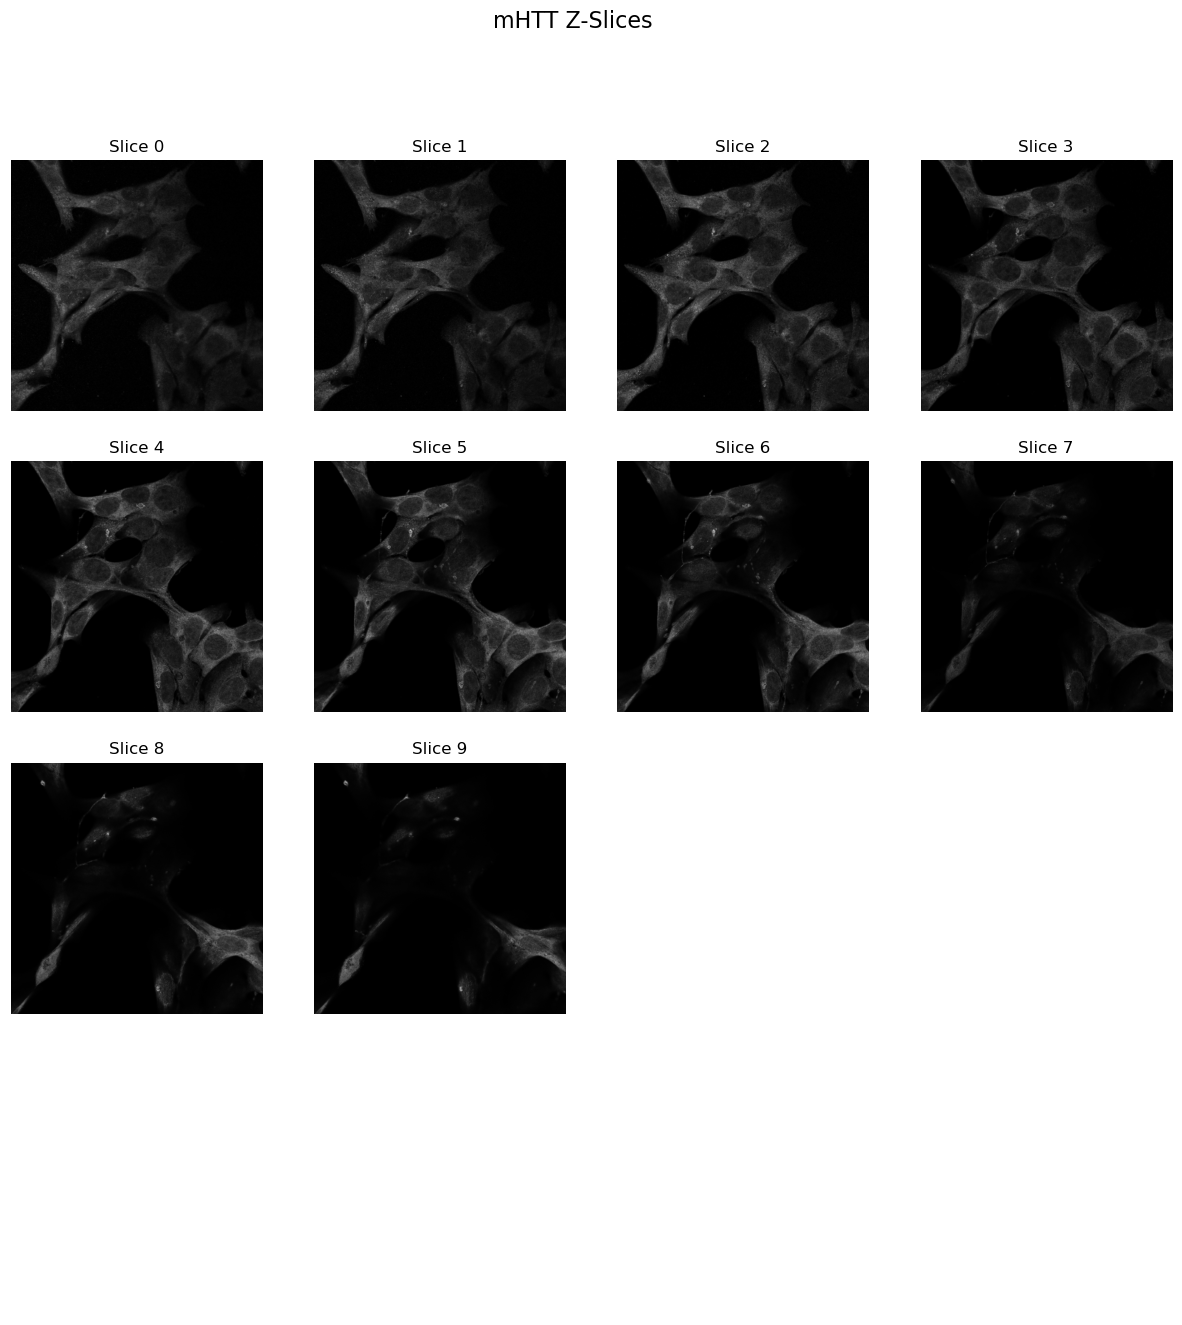

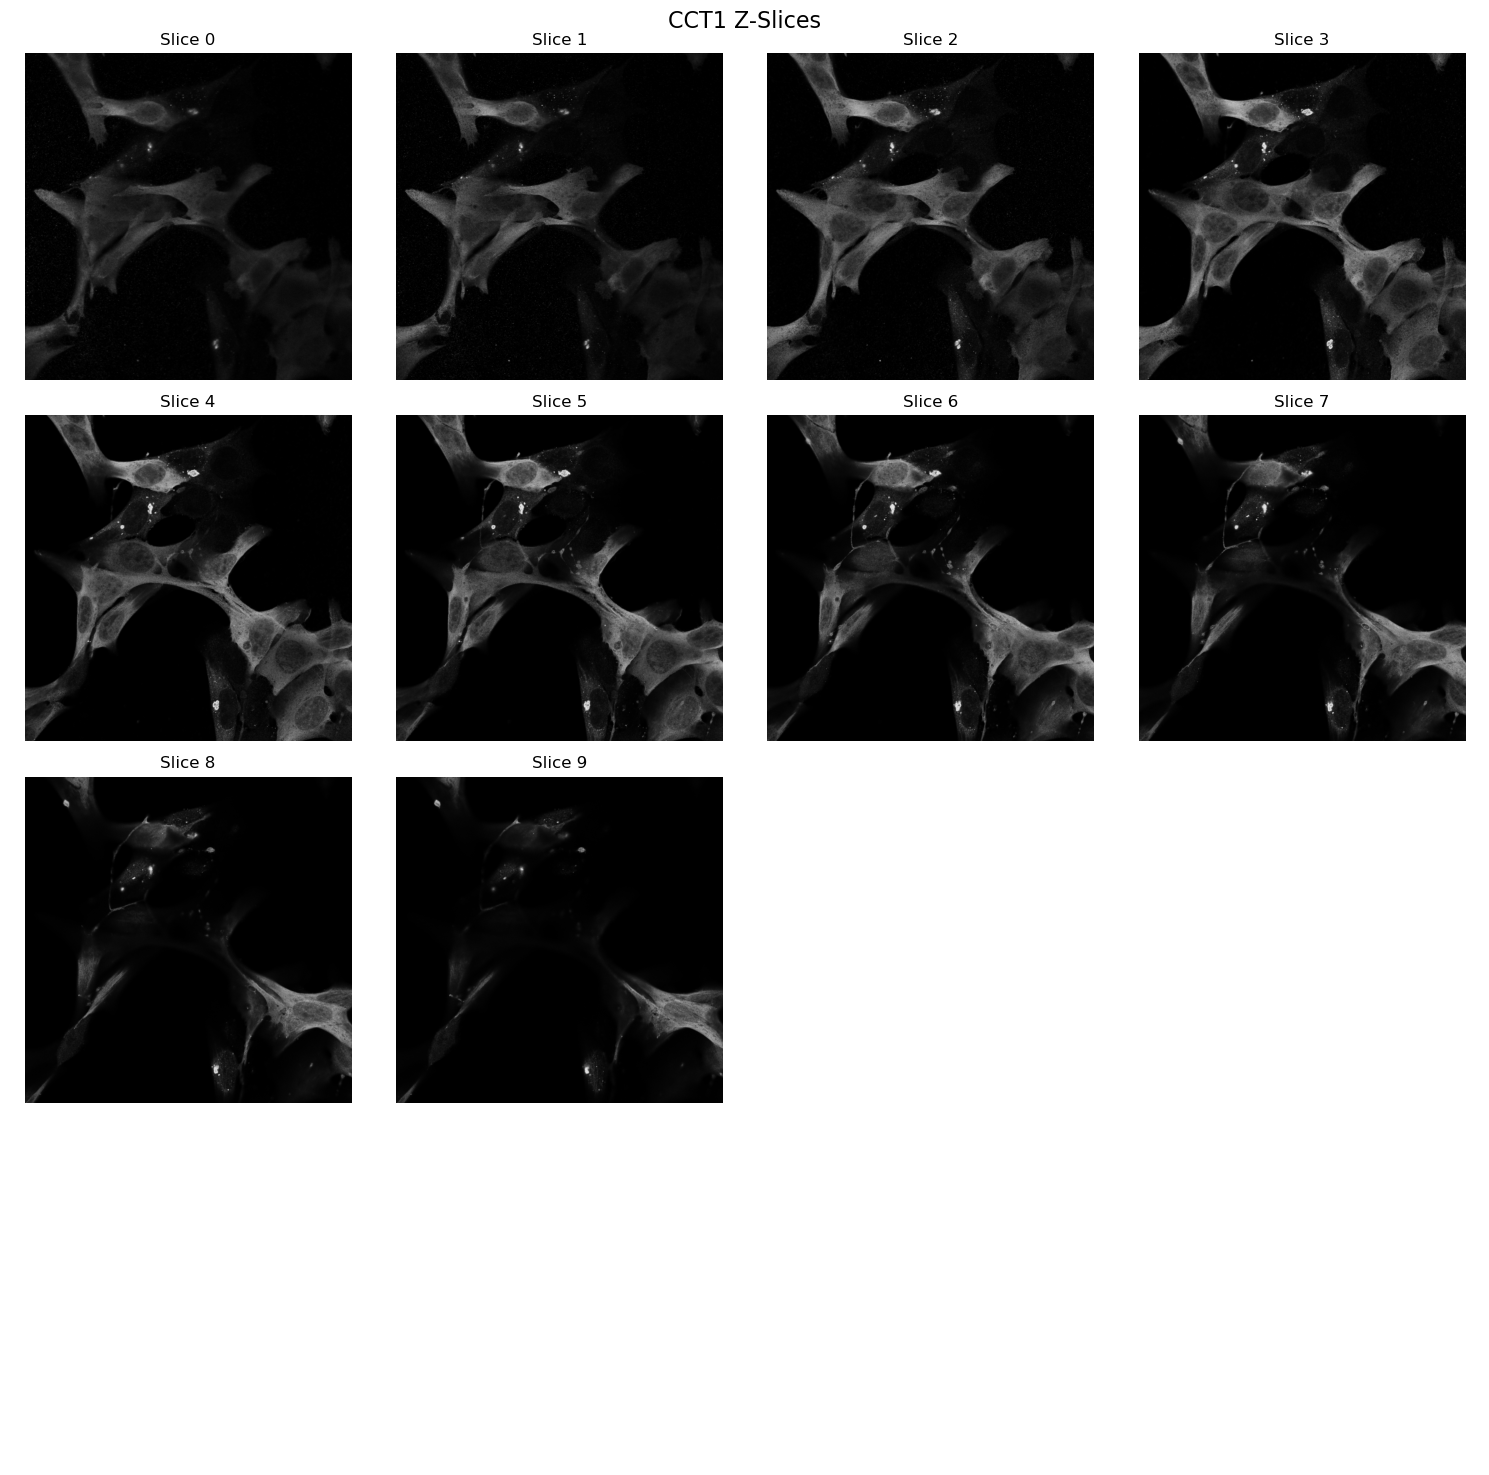

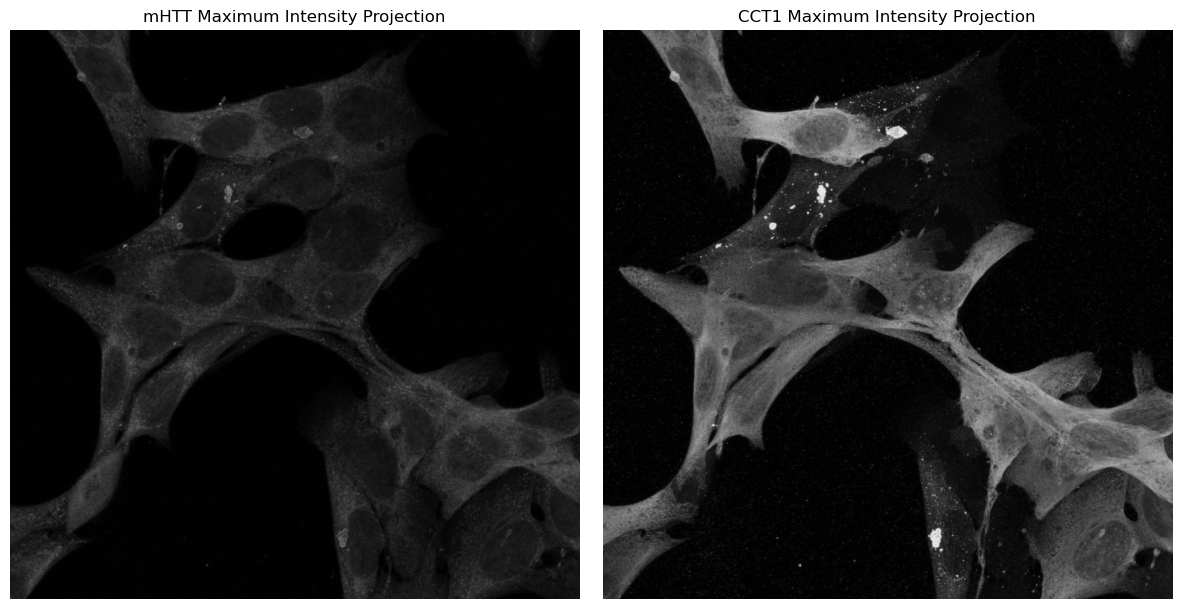

In [2]:


# File paths
mhtt_path = '/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/20240212_CKR_E10B_mHtt-HAQ97doxy48h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_3.lif - C=0.tif'
cct1_path = '/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/20240212_CKR_E10B_mHtt-HAQ97doxy48h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_3.lif - C=1.tif'

# Load the TIFF files
mhtt_data = tifffile.imread(mhtt_path)  # Shape: (Z, Y, X)
cct1_data = tifffile.imread(cct1_path)  # Shape: (Z, Y, X)

# Verify the shapes
print(f"mHTT data shape: {mhtt_data.shape}")
print(f"CCT1 data shape: {cct1_data.shape}")

# Create output directories for Z-slices
mhtt_output_dir = "mhtt_z_slices"
cct1_output_dir = "cct1_z_slices"
os.makedirs(mhtt_output_dir, exist_ok=True)
os.makedirs(cct1_output_dir, exist_ok=True)

# Save each Z-slice as a separate TIFF file
for z in range(mhtt_data.shape[0]):
    mhtt_slice_path = os.path.join(mhtt_output_dir, f"mhtt_slice_{z}.tiff")
    cct1_slice_path = os.path.join(cct1_output_dir, f"cct1_slice_{z}.tiff")
    
    # Save mHTT Z-slice
    tifffile.imwrite(mhtt_slice_path, mhtt_data[z])
    
    # Save CCT1 Z-slice
    tifffile.imwrite(cct1_slice_path, cct1_data[z])

print(f"Saved {mhtt_data.shape[0]} Z-slices for mHTT to '{mhtt_output_dir}'")
print(f"Saved {cct1_data.shape[0]} Z-slices for CCT1 to '{cct1_output_dir}'")

# Display all Z-slices in a grid
num_slices = mhtt_data.shape[0]
grid_size = int(np.ceil(np.sqrt(num_slices)))

# Create a figure to display all mHTT Z-slices
fig1, axes1 = plt.subplots(grid_size, grid_size, figsize=(15, 15))
fig1.suptitle('mHTT Z-Slices', fontsize=16)

# Create a figure to display all CCT1 Z-slices
fig2, axes2 = plt.subplots(grid_size, grid_size, figsize=(15, 15))
fig2.suptitle('CCT1 Z-Slices', fontsize=16)

# Normalize the intensity for better visualization
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

# Plot each Z-slice
for z in range(num_slices):
    row, col = z // grid_size, z % grid_size
    
    # mHTT slice
    ax1 = axes1[row, col]
    ax1.imshow(normalize(mhtt_data[z]), cmap='gray')
    ax1.set_title(f"Slice {z}")
    ax1.axis('off')
    
    # CCT1 slice
    ax2 = axes2[row, col]
    ax2.imshow(normalize(cct1_data[z]), cmap='gray')
    ax2.set_title(f"Slice {z}")
    ax2.axis('off')

# Turn off remaining empty subplots
for z in range(num_slices, grid_size**2):
    row, col = z // grid_size, z % grid_size
    axes1[row, col].axis('off')
    axes2[row, col].axis('off')

plt.tight_layout()
plt.show()

# Create maximum intensity projections (MIP)
mhtt_mip = np.max(mhtt_data, axis=0)
cct1_mip = np.max(cct1_data, axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(normalize(mhtt_mip), cmap='gray')
plt.title("mHTT Maximum Intensity Projection")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(normalize(cct1_mip), cmap='gray')
plt.title("CCT1 Maximum Intensity Projection")
plt.axis('off')

plt.tight_layout()
plt.show()


when combining the slices for visualization, I use a maximum intensity projection (MIP). It works like this:
	•	It goes through each pixel column in the Z-stack (i.e., the same (X, Y) position across all Z-layers).
	•	For each (X, Y) pixel location, I select the maximum intensity value from all Z-slices.
	•	The result is a single 2D image where each pixel shows the brightest value observed in that column of Z-slices.

This just for visualization, the actual analysis is performed across different z-slices

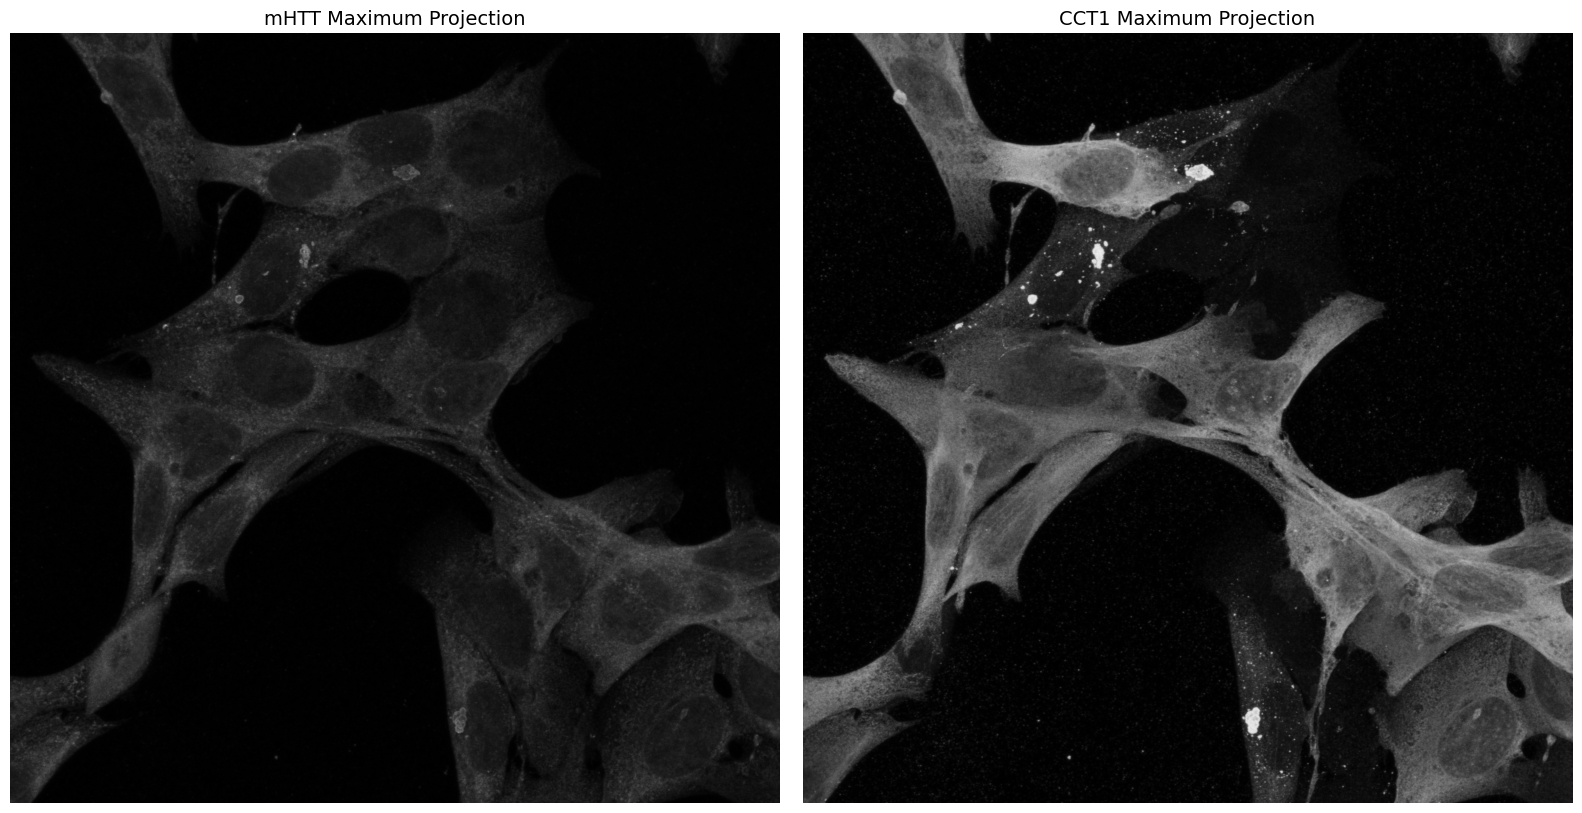

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import os

# Extract and prepare image data for mHTT
# Load mHTT data (returns a 3D stack with shape [Z, Y, X])
mhtt_data = tifffile.imread(mhtt_path)
cct1_data = tifffile.imread(cct1_path)

# Create a maximum intensity projection
mhtt_proj = np.max(mhtt_data, axis=0)
cct1_proj = np.max(cct1_data, axis=0)

# Normalize to 0-1 range for better visualization
mhtt_norm = (mhtt_proj - np.min(mhtt_proj)) / np.ptp(mhtt_proj)
cct1_norm = (cct1_proj - np.min(cct1_proj)) / np.ptp(cct1_proj)

# Display the mHTT and CCT1 images side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mhtt_norm, cmap='gray')
axs[0].set_title("mHTT Maximum Projection", fontsize=14)
axs[0].axis('off')

axs[1].imshow(cct1_norm, cmap='gray')
axs[1].set_title("CCT1 Maximum Projection", fontsize=14)
axs[1].axis('off')
plt.tight_layout()
plt.show()

# Add interactive controls using ipywidgets

def update_visualization(mhtt_strictness=4.0, cct1_strictness=4.0, 
                         sigma=1.0, min_size=20, mhtt_color='green', 
                         cct1_color='red', show_overlap_only=False):
    """Update visualization based on slider values"""
    # Apply Gaussian blur with adjustable sigma
    mhtt_smooth = gaussian(mhtt_norm, sigma=sigma)
    cct1_smooth = gaussian(cct1_norm, sigma=sigma)
    
    # Get Otsu thresholds
    mhtt_otsu = threshold_otsu(mhtt_smooth)
    cct1_otsu = threshold_otsu(cct1_smooth)
    
    # Apply strictness factor from sliders
    mhtt_threshold = min(1.0, mhtt_otsu * mhtt_strictness)
    cct1_threshold = min(1.0, cct1_otsu * cct1_strictness)
    
    # Create binary masks
    mhtt_mask = mhtt_smooth > mhtt_threshold
    cct1_mask = cct1_smooth > cct1_threshold
    
    # Clean up small noise artifacts
    mhtt_mask = remove_small_objects(mhtt_mask, min_size=min_size)
    cct1_mask = remove_small_objects(cct1_mask, min_size=min_size)
    
    # Create an overlap mask where both are active
    overlap_mask = mhtt_mask & cct1_mask
    
    # Prepare color mapping - using RGB channels directly for better control
    composite = np.zeros((mhtt_norm.shape[0], mhtt_norm.shape[1], 3))
    
    # Configure colors based on selections
    color_map = {'red': 0, 'green': 1, 'blue': 2, 'magenta': [0,2], 'yellow': [0,1], 'cyan': [1,2]}
    
    if not show_overlap_only:
        # Add mHTT channel
        if mhtt_color in ['red', 'green', 'blue']:
            composite[:,:,color_map[mhtt_color]] = mhtt_norm * mhtt_mask
        else:  # Handle combined colors
            for channel in color_map[mhtt_color]:
                composite[:,:,channel] = mhtt_norm * mhtt_mask
        
        # Add CCT1 channel
        if cct1_color in ['red', 'green', 'blue']:
            composite[:,:,color_map[cct1_color]] = cct1_norm * cct1_mask
        else:  # Handle combined colors
            for channel in color_map[cct1_color]:
                composite[:,:,channel] = cct1_norm * cct1_mask
    else:
        # Only show overlap
        if mhtt_color in ['red', 'green', 'blue'] and cct1_color in ['red', 'green', 'blue']:
            composite[:,:,color_map[mhtt_color]] = mhtt_norm * overlap_mask
            composite[:,:,color_map[cct1_color]] = cct1_norm * overlap_mask
    
    # Display the results
    plt.figure(figsize=(10, 10))
    plt.imshow(composite)
    
    # Create informative title
    title = f"Thresholds: mHTT>{mhtt_threshold:.2f}, CCT1>{cct1_threshold:.2f}"
    if show_overlap_only:
        title += " (Overlap Only)"
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Display metrics
    mhtt_area = np.sum(mhtt_mask)
    cct1_area = np.sum(cct1_mask)
    overlap_area = np.sum(overlap_mask)
    
    print(f"mHTT area: {mhtt_area} pixels")
    print(f"CCT1 area: {cct1_area} pixels")
    print(f"Overlap area: {overlap_area} pixels")
    print(f"Overlap percentage: {100*overlap_area/mhtt_area:.2f}% of mHTT, {100*overlap_area/cct1_area:.2f}% of CCT1")
    
    return mhtt_mask, cct1_mask, overlap_mask, mhtt_threshold, cct1_threshold

# Function to run comprehensive colocalization analysis
def run_colocalization_analysis(b):
    
    # Create directory for reports if it doesn't exist
    report_dir = "colocalization_reports"
    if not os.path.exists(report_dir):
        os.makedirs(report_dir)
    
    # Generate timestamp for the filename
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    pdf_filename = os.path.join(report_dir, f"colocalization_report_{timestamp}.pdf")
    
    # Get current parameter values
    mhtt_strictness = mhtt_strictness_slider.value
    cct1_strictness = cct1_strictness_slider.value
    sigma = sigma_slider.value
    min_size = min_size_slider.value
    
    # Generate masks using current parameters
    mhtt_mask, cct1_mask, overlap_mask, mhtt_threshold, cct1_threshold = update_visualization(
        mhtt_strictness, cct1_strictness, sigma, min_size, 
        mhtt_color.value, cct1_color.value, overlap_toggle.value
    )
    
    # Create union mask
    union_mask = mhtt_mask | cct1_mask
    
    # 1. Pearson's Correlation Coefficient
    # Get intensity values within the masks
    mhtt_values = mhtt_norm[union_mask]
    cct1_values = cct1_norm[union_mask]
    pearson_corr, pearson_p = pearsonr(mhtt_values, cct1_values)
    
    # 2. Manders' Coefficients
    # M1: fraction of mHTT overlapping with CCT1
    m1 = np.sum(mhtt_norm * overlap_mask) / np.sum(mhtt_norm * mhtt_mask) if np.sum(mhtt_norm * mhtt_mask) > 0 else 0
    # M2: fraction of CCT1 overlapping with mHTT
    m2 = np.sum(cct1_norm * overlap_mask) / np.sum(cct1_norm * cct1_mask) if np.sum(cct1_norm * cct1_mask) > 0 else 0
    
    # 3. Dice similarity coefficient
    dice = 2 * np.sum(overlap_mask) / (np.sum(mhtt_mask) + np.sum(cct1_mask)) if (np.sum(mhtt_mask) + np.sum(cct1_mask)) > 0 else 0
    
    # 4. Mann-Whitney U Test
    # Compare intensity distributions within the two masks
    mhtt_inside = mhtt_norm[mhtt_mask & ~cct1_mask].flatten()
    mhtt_overlap = mhtt_norm[overlap_mask].flatten()
    if len(mhtt_inside) > 0 and len(mhtt_overlap) > 0:
        u_stat, p_value = mannwhitneyu(mhtt_inside, mhtt_overlap, alternative='two-sided')
    else:
        u_stat, p_value = 0, 1
    
    # 5. Cohen's d (effect size)
    if len(mhtt_inside) > 0 and len(mhtt_overlap) > 0:
        mean_in = np.mean(mhtt_overlap)
        mean_out = np.mean(mhtt_inside)
        std_in = np.std(mhtt_overlap)
        std_out = np.std(mhtt_inside)
        pooled_std = np.sqrt(((len(mhtt_overlap) - 1) * std_in**2 + (len(mhtt_inside) - 1) * std_out**2) / 
                             (len(mhtt_overlap) + len(mhtt_inside) - 2))
        cohen_d = abs(mean_in - mean_out) / pooled_std if pooled_std > 0 else 0
    else:
        mean_in, mean_out, cohen_d = 0, 0, 0
    
    # 6. Intersection over Union (IoU)
    iou = np.sum(overlap_mask) / np.sum(union_mask) if np.sum(union_mask) > 0 else 0
    
    # Display results
    print("\n===== COLOCALIZATION ANALYSIS RESULTS =====")
    print(f"Parameters: mHTT factor={mhtt_strictness}, CCT1 factor={cct1_strictness}, sigma={sigma}, min_size={min_size}")
    print(f"Thresholds: mHTT>{mhtt_threshold:.4f}, CCT1>{cct1_threshold:.4f}")
    
    print("\n1. Pearson's Correlation Coefficient:")
    print(f"   r = {pearson_corr:.4f} (p-value: {pearson_p:.8e})")
    
    print("\n2. Manders' Coefficients:")
    print(f"   M1 (fraction of mHTT overlapping with CCT1) = {m1:.4f}")
    print(f"   M2 (fraction of CCT1 overlapping with mHTT) = {m2:.4f}")
    
    print("\n3. Dice Similarity Coefficient:")
    print(f"   Dice = {dice:.4f}")
    
    print("\n4. Mann-Whitney U Test:")
    print(f"   U = {u_stat:.2f}")
    print(f"   p-value = {p_value:.8e}")
    
    print("\n5. Cohen's d (Effect Size):")
    print(f"   d = {cohen_d:.4f}")
    print(f"   Mean intensity in overlap: {mean_in:.2f}")
    print(f"   Mean intensity outside overlap: {mean_out:.2f}")
    
    print("\n6. Intersection over Union (IoU):")
    print(f"   IoU = {iou:.4f}")
    
    # Create figures for PDF export
    # Visualization of results
    fig_results, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Show mHTT with mask outline
    axs[0].imshow(mhtt_norm, cmap='gray')
    axs[0].contour(mhtt_mask, colors='green', linewidths=0.5)
    axs[0].set_title("mHTT with Threshold Contour", fontsize=14)
    axs[0].axis('off')
    
    # Show CCT1 with mask outline
    axs[1].imshow(cct1_norm, cmap='gray')
    axs[1].contour(cct1_mask, colors='red', linewidths=0.5)
    axs[1].set_title("CCT1 with Threshold Contour", fontsize=14)
    axs[1].axis('off')
    
    # Show overlap visualization
    overlap_img = np.zeros((mhtt_norm.shape[0], mhtt_norm.shape[1], 3))
    overlap_img[:,:,1] = mhtt_norm * mhtt_mask  # Green channel for mHTT
    overlap_img[:,:,0] = cct1_norm * cct1_mask  # Red channel for CCT1
    overlap_img = np.clip(overlap_img, 0, 1)
    
    axs[2].imshow(overlap_img)
    axs[2].set_title("Colocalization Map", fontsize=14)
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Create PDF report
    with PdfPages(pdf_filename) as pdf:
        # Title page
        fig_title = plt.figure(figsize=(8.5, 11))
        fig_title.suptitle("Colocalization Analysis Report", fontsize=16, y=0.95)
        plt.figtext(0.5, 0.85, f"Generated on: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", 
                   ha='center', fontsize=12)
        plt.figtext(0.5, 0.80, f"mHTT Path: {os.path.basename(mhtt_path)}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.77, f"CCT1 Path: {os.path.basename(cct1_path)}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.72, "Analysis Parameters:", ha='center', fontsize=12, weight='bold')
        plt.figtext(0.5, 0.68, f"mHTT threshold factor: {mhtt_strictness}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.65, f"CCT1 threshold factor: {cct1_strictness}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.62, f"Gaussian sigma: {sigma}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.59, f"Min object size: {min_size} pixels", ha='center', fontsize=10)
        plt.figtext(0.5, 0.56, f"mHTT color: {mhtt_color.value}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.53, f"CCT1 color: {cct1_color.value}", ha='center', fontsize=10)
        plt.axis('off')
        pdf.savefig(fig_title)
        plt.close(fig_title)
        
        # Results summary page
        fig_summary = plt.figure(figsize=(8.5, 11))
        fig_summary.suptitle("Colocalization Metrics Summary", fontsize=16, y=0.95)
        
        # Basic metrics
        plt.figtext(0.1, 0.90, "Basic Metrics:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.87, f"mHTT area: {np.sum(mhtt_mask)} pixels", fontsize=10)
        plt.figtext(0.1, 0.84, f"CCT1 area: {np.sum(cct1_mask)} pixels", fontsize=10)
        plt.figtext(0.1, 0.81, f"Overlap area: {np.sum(overlap_mask)} pixels", fontsize=10)
        plt.figtext(0.1, 0.78, f"Overlap percentage: {100*np.sum(overlap_mask)/np.sum(mhtt_mask):.2f}% of mHTT, {100*np.sum(overlap_mask)/np.sum(cct1_mask):.2f}% of CCT1", fontsize=10)
        
        # Detailed metrics
        plt.figtext(0.1, 0.73, "1. Pearson's Correlation Coefficient:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.70, f"   r = {pearson_corr:.4f} (p-value: {pearson_p:.8e})", fontsize=10)
        
        plt.figtext(0.1, 0.65, "2. Manders' Coefficients:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.62, f"   M1 (fraction of mHTT overlapping with CCT1) = {m1:.4f}", fontsize=10)
        plt.figtext(0.1, 0.59, f"   M2 (fraction of CCT1 overlapping with mHTT) = {m2:.4f}", fontsize=10)
        
        plt.figtext(0.1, 0.54, "3. Dice Similarity Coefficient:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.51, f"   Dice = {dice:.4f}", fontsize=10)
        
        plt.figtext(0.1, 0.46, "4. Mann-Whitney U Test:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.43, f"   U = {u_stat:.2f}", fontsize=10)
        plt.figtext(0.1, 0.40, f"   p-value = {p_value:.8e}", fontsize=10)
        
        plt.figtext(0.1, 0.35, "5. Cohen's d (Effect Size):", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.32, f"   d = {cohen_d:.4f}", fontsize=10)
        plt.figtext(0.1, 0.29, f"   Mean intensity in overlap: {mean_in:.2f}", fontsize=10)
        plt.figtext(0.1, 0.26, f"   Mean intensity outside overlap: {mean_out:.2f}", fontsize=10)
        
        plt.figtext(0.1, 0.21, "6. Intersection over Union (IoU):", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.18, f"   IoU = {iou:.4f}", fontsize=10)
        
        plt.figtext(0.5, 0.05, f"Report saved to: {pdf_filename}", ha='center', fontsize=8, style='italic')
        plt.axis('off')
        pdf.savefig(fig_summary)
        plt.close(fig_summary)
        
        # Add visualization page
        pdf.savefig(fig_results)
        plt.close(fig_results)
        
    print(f"\nPDF report generated and saved to: {pdf_filename}")
    
# Create sliders
mhtt_strictness_slider = widgets.FloatSlider(
    value=4.0, min=1.0, max=10.0, step=0.5, 
    description='mHTT Factor:',
    style={'description_width': 'initial'}
)

cct1_strictness_slider = widgets.FloatSlider(
    value=4.0, min=1.0, max=10.0, step=0.5, 
    description='CCT1 Factor:',
    style={'description_width': 'initial'}
)

sigma_slider = widgets.FloatSlider(
    value=1.0, min=0.1, max=5.0, step=0.1,
    description='Gaussian σ:',
    style={'description_width': 'initial'}
)

min_size_slider = widgets.IntSlider(
    value=20, min=1, max=100, step=5,
    description='Min Size:',
    style={'description_width': 'initial'}
)

mhtt_color = widgets.Dropdown(
    options=['red', 'green', 'blue', 'magenta', 'yellow', 'cyan'],
    value='green',
    description='mHTT Color:',
    style={'description_width': 'initial'}
)

cct1_color = widgets.Dropdown(
    options=['red', 'green', 'blue', 'magenta', 'yellow', 'cyan'],
    value='red',
    description='CCT1 Color:',
    style={'description_width': 'initial'}
)

overlap_toggle = widgets.Checkbox(
    value=False,
    description='Show overlap only',
    style={'description_width': 'initial'}
)

# Add button for colocalization analysis
colocalize_button = widgets.Button(
    description='Run Colocalization Analysis',
    button_style='success',
    tooltip='Calculate advanced colocalization metrics with current parameters'
)

# Connect the button to the function
colocalize_button.on_click(run_colocalization_analysis)

# Create interactive widget
interactive_plot = widgets.interactive(
    update_visualization,
    mhtt_strictness=mhtt_strictness_slider,
    cct1_strictness=cct1_strictness_slider,
    sigma=sigma_slider,
    min_size=min_size_slider,
    mhtt_color=mhtt_color,
    cct1_color=cct1_color,
    show_overlap_only=overlap_toggle
)

# Display the widget and the button
display(widgets.VBox([interactive_plot, colocalize_button]))


the code from here on is a watershed method

In [4]:
# Thresholding
thresh_mhtt = threshold_otsu(mhtt_proj)
thresh_cct1 = threshold_otsu(cct1_proj)

# Binary masks
mask_mhtt = mhtt_proj > thresh_mhtt
mask_cct1 = cct1_proj > thresh_cct1

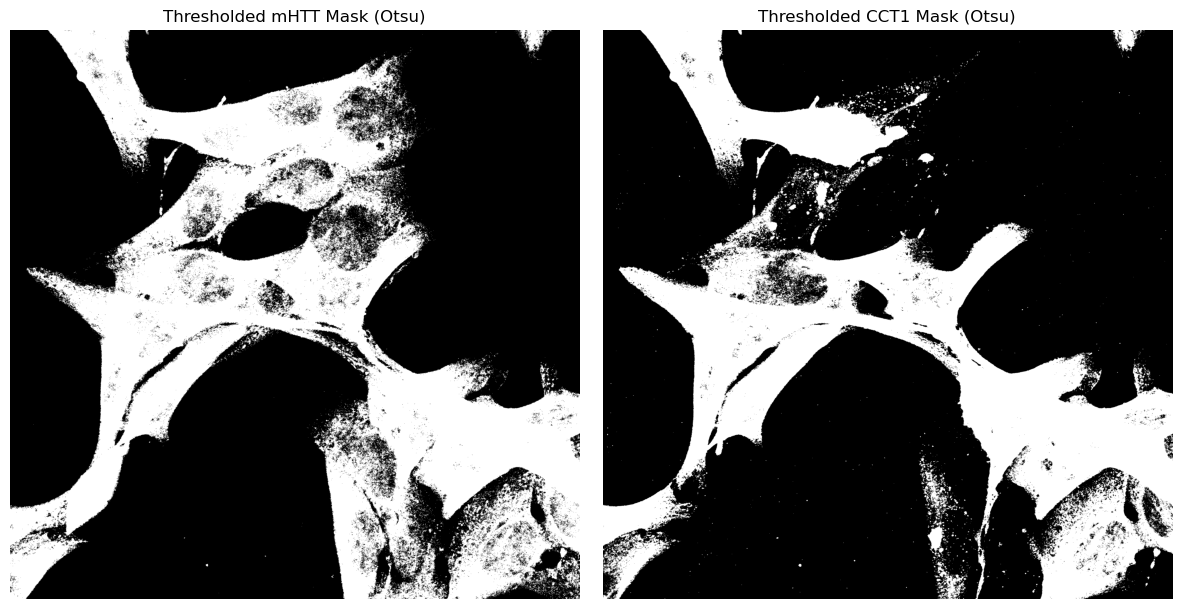

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# mHTT mask
axs[0].imshow(mask_mhtt, cmap='gray')
axs[0].set_title("Thresholded mHTT Mask (Otsu)")
axs[0].axis('off')

# CCT1 mask
axs[1].imshow(mask_cct1, cmap='gray')
axs[1].set_title("Thresholded CCT1 Mask (Otsu)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

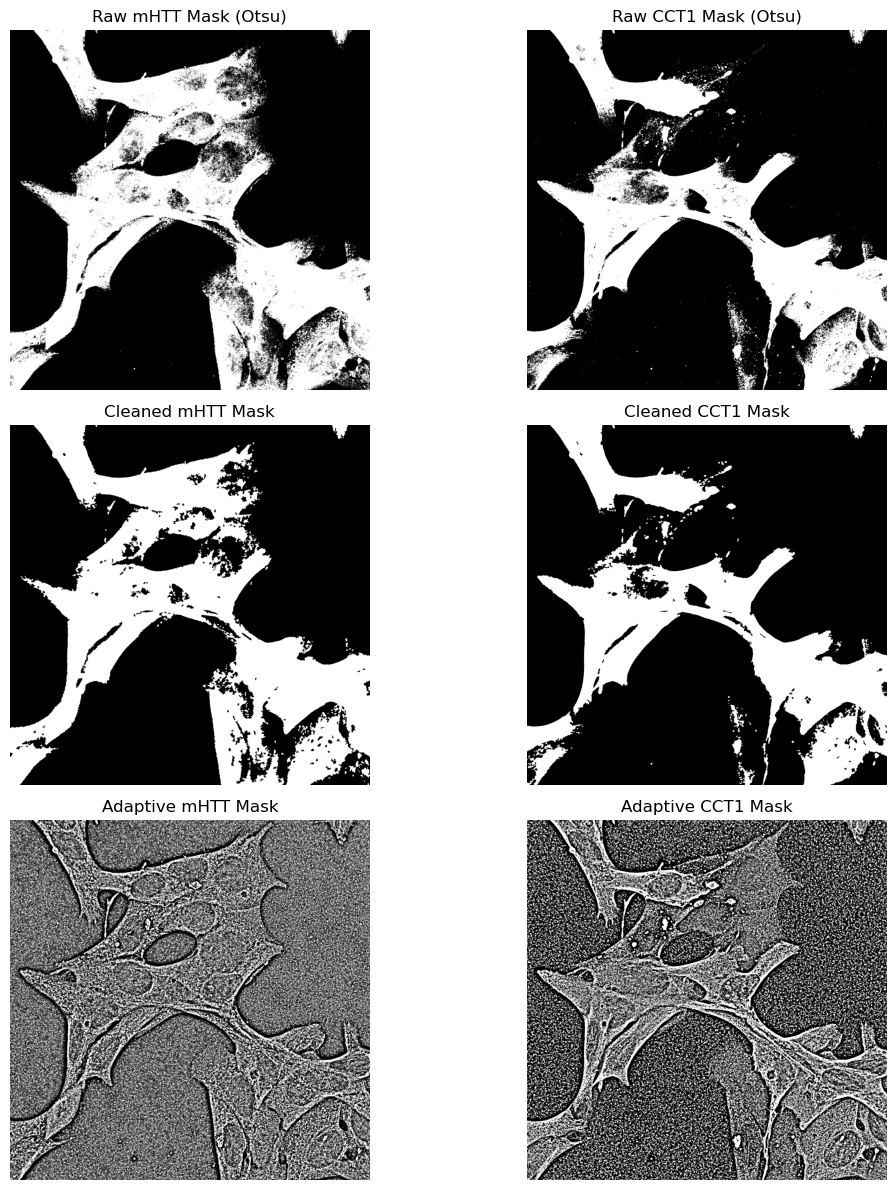

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_local
from skimage.morphology import (
    remove_small_objects,
    remove_small_holes,
    binary_opening,
    disk
)

# --- Threshold with Otsu ---
thresh_mhtt = threshold_otsu(mhtt_proj)
thresh_cct1 = threshold_otsu(cct1_proj)

mask_mhtt = mhtt_proj > thresh_mhtt
mask_cct1 = cct1_proj > thresh_cct1

# --- Morphological cleanup (Otsu masks) ---
mask_mhtt_clean = remove_small_objects(mask_mhtt, min_size=64)
mask_mhtt_clean = remove_small_holes(mask_mhtt_clean, area_threshold=64)
mask_mhtt_clean = binary_opening(mask_mhtt_clean, footprint=disk(2))

mask_cct1_clean = remove_small_objects(mask_cct1, min_size=64)
mask_cct1_clean = remove_small_holes(mask_cct1_clean, area_threshold=64)
mask_cct1_clean = binary_opening(mask_cct1_clean, footprint=disk(2))

# --- (Optional) Adaptive Thresholding ---
adaptive_thresh_mhtt = threshold_local(mhtt_proj, block_size=51, offset=10)
adaptive_mask_mhtt = mhtt_proj > adaptive_thresh_mhtt

adaptive_thresh_cct1 = threshold_local(cct1_proj, block_size=51, offset=10)
adaptive_mask_cct1 = cct1_proj > adaptive_thresh_cct1

# --- Visualization ---
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].imshow(mask_mhtt, cmap='gray')
axs[0, 0].set_title("Raw mHTT Mask (Otsu)")
axs[0, 1].imshow(mask_cct1, cmap='gray')
axs[0, 1].set_title("Raw CCT1 Mask (Otsu)")

axs[1, 0].imshow(mask_mhtt_clean, cmap='gray')
axs[1, 0].set_title("Cleaned mHTT Mask")
axs[1, 1].imshow(mask_cct1_clean, cmap='gray')
axs[1, 1].set_title("Cleaned CCT1 Mask")

axs[2, 0].imshow(adaptive_mask_mhtt, cmap='gray')
axs[2, 0].set_title("Adaptive mHTT Mask")
axs[2, 1].imshow(adaptive_mask_cct1, cmap='gray')
axs[2, 1].set_title("Adaptive CCT1 Mask")

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

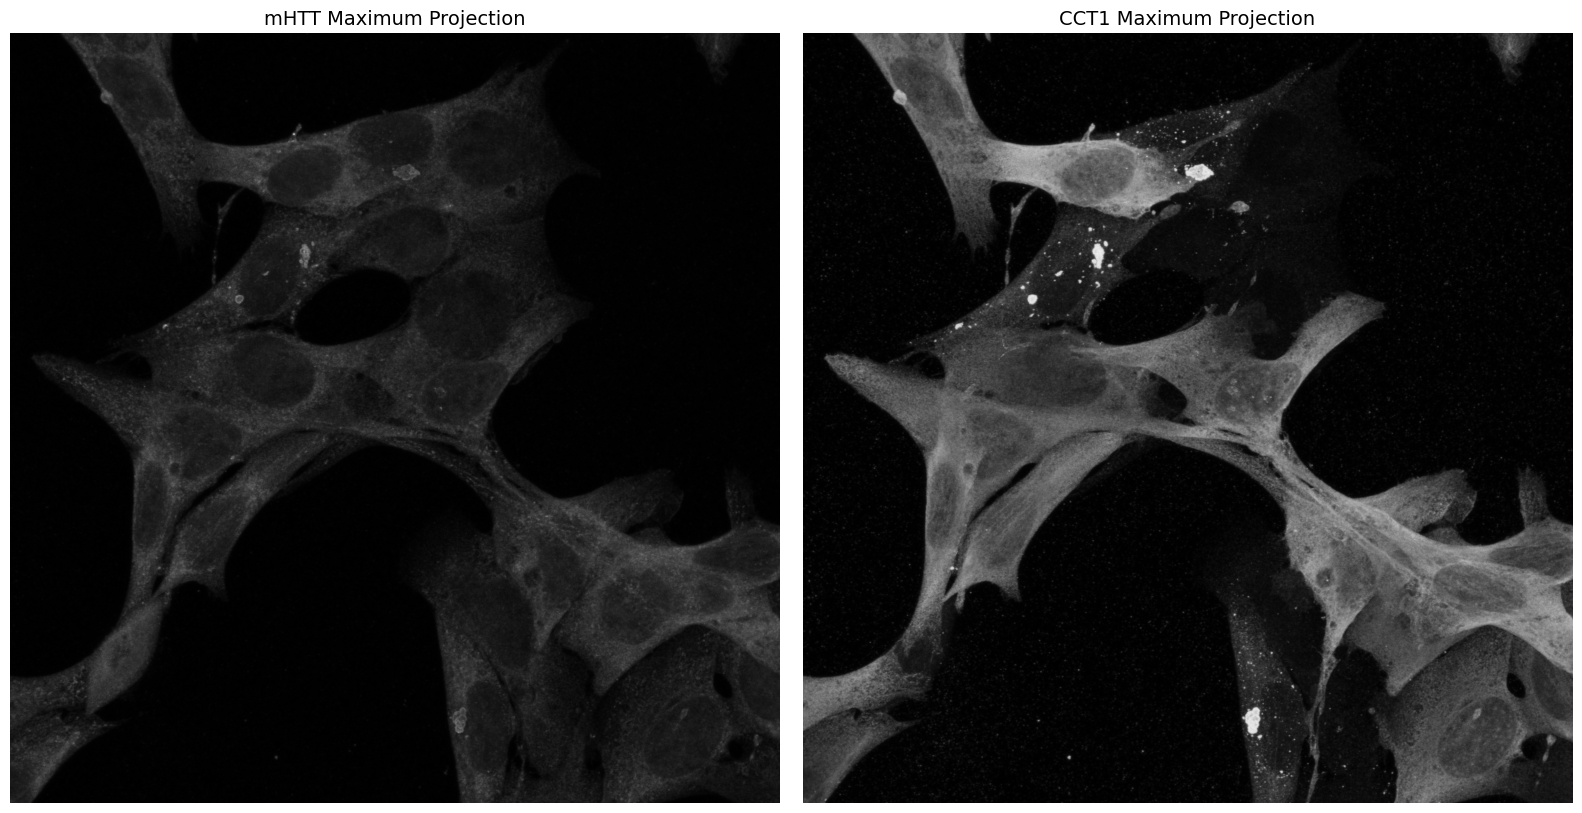

interactive(children=(FloatSlider(value=4.0, description='mHTT Factor:', max=10.0, min=1.0, step=0.5, style=Sl…

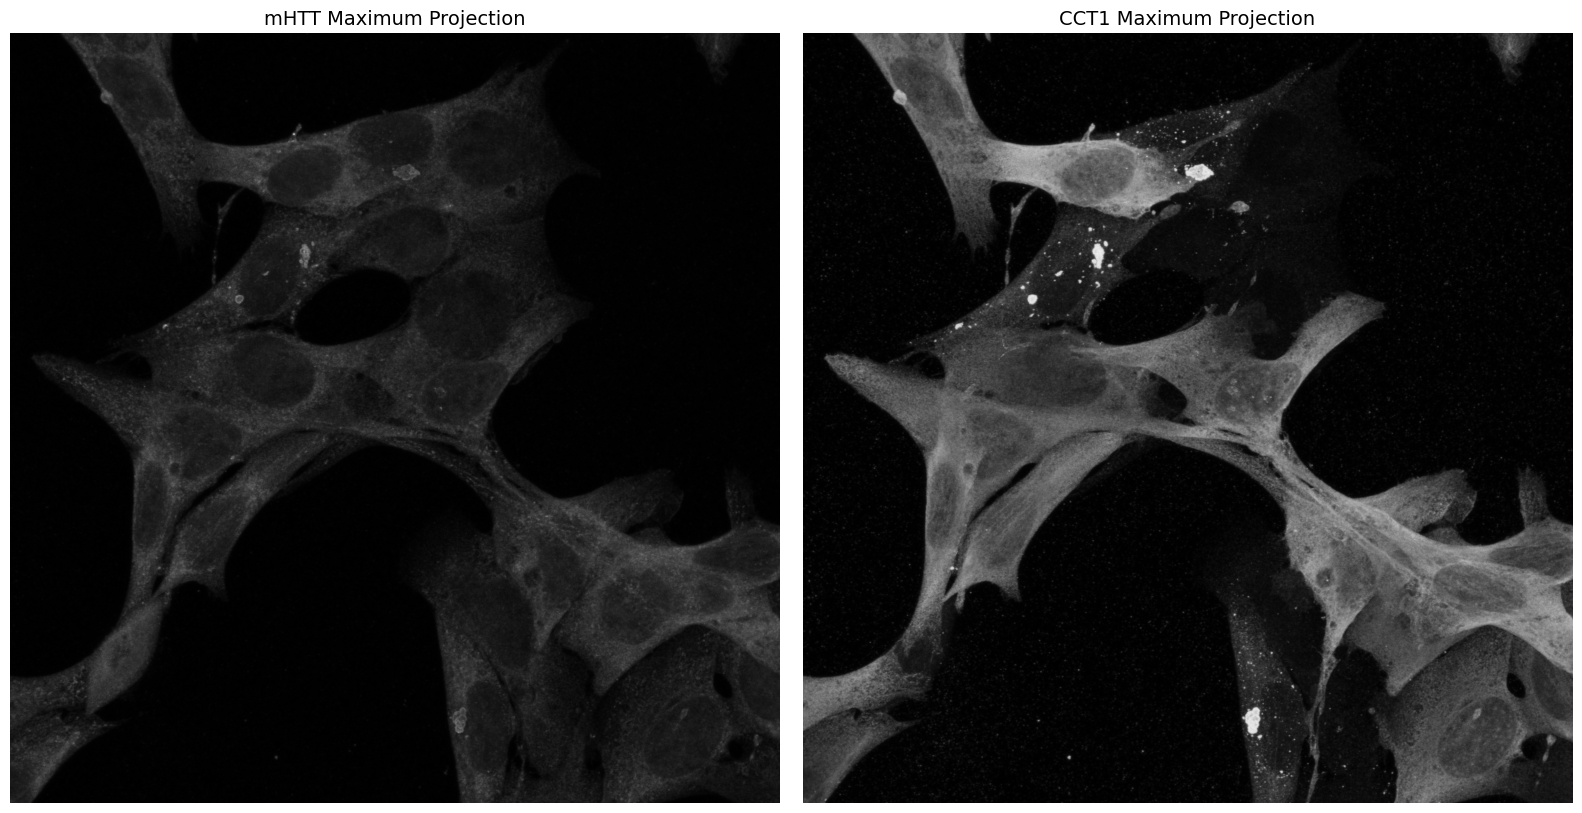

interactive(children=(FloatSlider(value=4.0, description='mHTT Factor:', max=10.0, min=1.0, step=0.5, style=Sl…

In [ ]:
# # Normalize the projection to [0, 1] for better contrast
# mhtt_proj = (mhtt_proj - np.min(mhtt_proj)) / np.ptp(mhtt_proj)

# # Optional: check it
# plt.imshow(mhtt_proj, cmap='gray')
# plt.title("Normalized Max Projection (All Z-slices)")
# plt.axis('off')
# plt.show()# Extract and prepare image data for mHTT
# Load mHTT data (returns a 3D stack with shape [Z, Y, X])
mhtt_data = tifffile.imread(mhtt_path)
cct1_data = tifffile.imread(cct1_path)

# Create a maximum intensity projection
mhtt_proj = np.max(mhtt_data, axis=0)
cct1_proj = np.max(cct1_data, axis=0)

# Normalize to 0-1 range for better visualization
mhtt_norm = (mhtt_proj - np.min(mhtt_proj)) / np.ptp(mhtt_proj)
cct1_norm = (cct1_proj - np.min(cct1_proj)) / np.ptp(cct1_proj)

# Display the mHTT and CCT1 images side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mhtt_norm, cmap='gray')
axs[0].set_title("mHTT Maximum Projection", fontsize=14)
axs[0].axis('off')

axs[1].imshow(cct1_norm, cmap='gray')
axs[1].set_title("CCT1 Maximum Projection", fontsize=14)
axs[1].axis('off')
plt.tight_layout()
plt.show()

# Add interactive controls using ipywidgets

def update_visualization(mhtt_strictness=4.0, cct1_strictness=4.0, 
                         sigma=1.0, min_size=20, mhtt_color='green', 
                         cct1_color='red', show_overlap_only=False):
    """Update visualization based on slider values"""
    # Apply Gaussian blur with adjustable sigma
    mhtt_smooth = gaussian(mhtt_norm, sigma=sigma)
    cct1_smooth = gaussian(cct1_norm, sigma=sigma)
    
    # Get Otsu thresholds
    mhtt_otsu = threshold_otsu(mhtt_smooth)
    cct1_otsu = threshold_otsu(cct1_smooth)
    
    # Apply strictness factor from sliders
    mhtt_threshold = min(1.0, mhtt_otsu * mhtt_strictness)
    cct1_threshold = min(1.0, cct1_otsu * cct1_strictness)
    
    # Create binary masks
    mhtt_mask = mhtt_smooth > mhtt_threshold
    cct1_mask = cct1_smooth > cct1_threshold
    
    # Clean up small noise artifacts
    mhtt_mask = remove_small_objects(mhtt_mask, min_size=min_size)
    cct1_mask = remove_small_objects(cct1_mask, min_size=min_size)
    
    # Create an overlap mask where both are active
    overlap_mask = mhtt_mask & cct1_mask
    
    # Prepare color mapping - using RGB channels directly for better control
    composite = np.zeros((mhtt_norm.shape[0], mhtt_norm.shape[1], 3))
    
    # Configure colors based on selections
    color_map = {'red': 0, 'green': 1, 'blue': 2, 'magenta': [0,2], 'yellow': [0,1], 'cyan': [1,2]}
    
    if not show_overlap_only:
        # Add mHTT channel
        if mhtt_color in ['red', 'green', 'blue']:
            composite[:,:,color_map[mhtt_color]] = mhtt_norm * mhtt_mask
        else:  # Handle combined colors
            for channel in color_map[mhtt_color]:
                composite[:,:,channel] = mhtt_norm * mhtt_mask
        
        # Add CCT1 channel
        if cct1_color in ['red', 'green', 'blue']:
            composite[:,:,color_map[cct1_color]] = cct1_norm * cct1_mask
        else:  # Handle combined colors
            for channel in color_map[cct1_color]:
                composite[:,:,channel] = cct1_norm * cct1_mask
    else:
        # Only show overlap
        if mhtt_color in ['red', 'green', 'blue'] and cct1_color in ['red', 'green', 'blue']:
            composite[:,:,color_map[mhtt_color]] = mhtt_norm * overlap_mask
            composite[:,:,color_map[cct1_color]] = cct1_norm * overlap_mask
    
    # Display the results
    plt.figure(figsize=(10, 10))
    plt.imshow(composite)
    
    # Create informative title
    title = f"Thresholds: mHTT>{mhtt_threshold:.2f}, CCT1>{cct1_threshold:.2f}"
    if show_overlap_only:
        title += " (Overlap Only)"
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Display metrics
    mhtt_area = np.sum(mhtt_mask)
    cct1_area = np.sum(cct1_mask)
    overlap_area = np.sum(overlap_mask)
    
    print(f"mHTT area: {mhtt_area} pixels")
    print(f"CCT1 area: {cct1_area} pixels")
    print(f"Overlap area: {overlap_area} pixels")
    print(f"Overlap percentage: {100*overlap_area/mhtt_area:.2f}% of mHTT, {100*overlap_area/cct1_area:.2f}% of CCT1")

# Create sliders
mhtt_strictness_slider = widgets.FloatSlider(
    value=4.0, min=1.0, max=10.0, step=0.5, 
    description='mHTT Factor:',
    style={'description_width': 'initial'}
)

cct1_strictness_slider = widgets.FloatSlider(
    value=4.0, min=1.0, max=10.0, step=0.5, 
    description='CCT1 Factor:',
    style={'description_width': 'initial'}
)

sigma_slider = widgets.FloatSlider(
    value=1.0, min=0.1, max=5.0, step=0.1,
    description='Gaussian σ:',
    style={'description_width': 'initial'}
)

min_size_slider = widgets.IntSlider(
    value=20, min=1, max=100, step=5,
    description='Min Size:',
    style={'description_width': 'initial'}
)

mhtt_color = widgets.Dropdown(
    options=['red', 'green', 'blue', 'magenta', 'yellow', 'cyan'],
    value='green',
    description='mHTT Color:',
    style={'description_width': 'initial'}
)

cct1_color = widgets.Dropdown(
    options=['red', 'green', 'blue', 'magenta', 'yellow', 'cyan'],
    value='red',
    description='CCT1 Color:',
    style={'description_width': 'initial'}
)

overlap_toggle = widgets.Checkbox(
    value=False,
    description='Show overlap only',
    style={'description_width': 'initial'}
)

# Create interactive widget
interactive_plot = widgets.interactive(
    update_visualization,
    mhtt_strictness=mhtt_strictness_slider,
    cct1_strictness=cct1_strictness_slider,
    sigma=sigma_slider,
    min_size=min_size_slider,
    mhtt_color=mhtt_color,
    cct1_color=cct1_color,
    show_overlap_only=overlap_toggle
)

# Display the widget
display(interactive_plot)


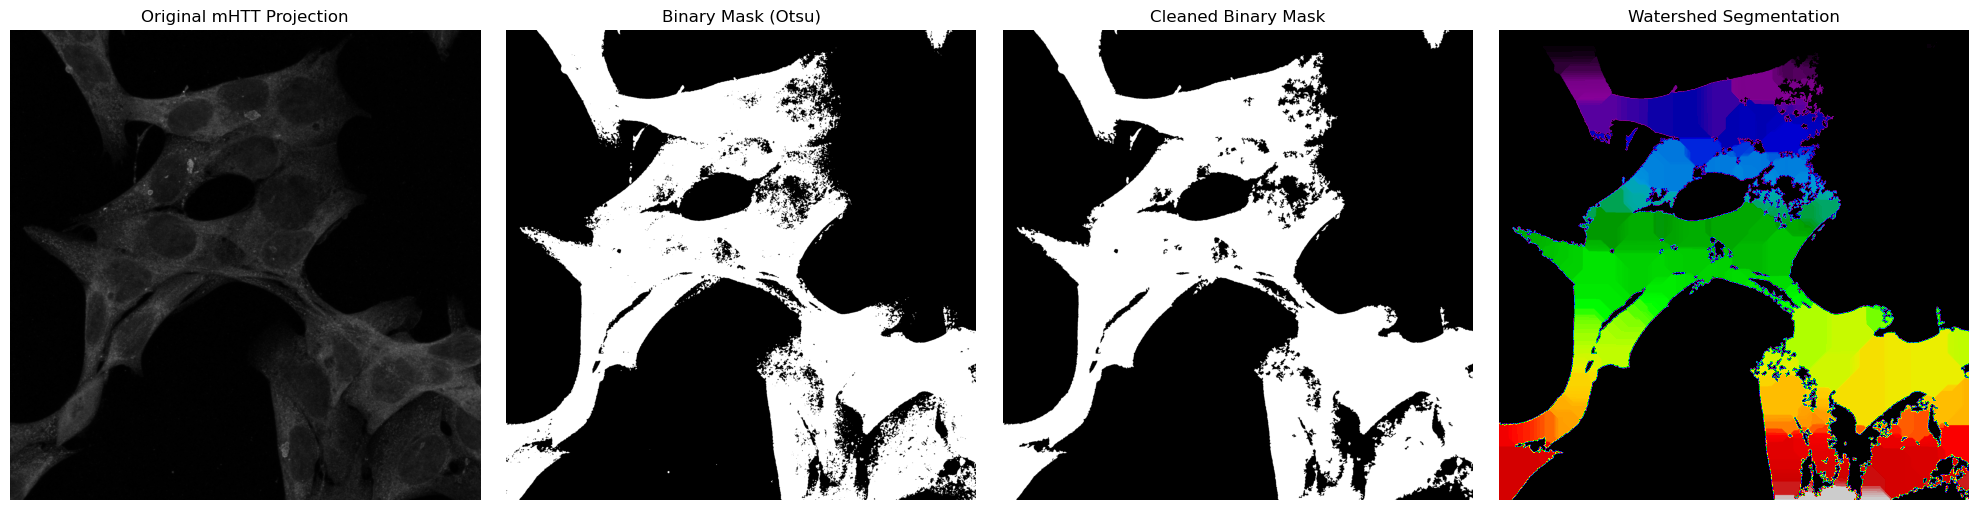

In [ ]:
# Step 1: Apply gaussian blur to reduce noise
mhtt_blurred = gaussian(mhtt_proj, sigma=1)

# Step 2: Otsu thresholding (skip adaptive)
binary_mask = mhtt_blurred > threshold_otsu(mhtt_blurred)

# Step 3: Aggressive morphological cleaning
binary_clean = remove_small_objects(binary_mask, min_size=100)
binary_clean = remove_small_holes(binary_clean, area_threshold=100)

# Step 4: Watershed segmentation
distance = ndi.distance_transform_edt(binary_clean)
coordinates = peak_local_max(distance, labels=binary_clean)
local_maxi = np.zeros_like(distance, dtype=bool)
local_maxi[tuple(coordinates.T)] = True
markers = ndi.label(local_maxi)[0]
labels_ws = watershed(-distance, markers, mask=binary_clean)

# Visualize all steps
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(mhtt_proj, cmap='gray')
axs[0].set_title("Original mHTT Projection")
axs[0].axis('off')

axs[1].imshow(binary_mask, cmap='gray')
axs[1].set_title("Binary Mask (Otsu)")
axs[1].axis('off')

axs[2].imshow(binary_clean, cmap='gray')
axs[2].set_title("Cleaned Binary Mask")
axs[2].axis('off')

axs[3].imshow(labels_ws, cmap='nipy_spectral')
axs[3].set_title("Watershed Segmentation")
axs[3].axis('off')

plt.tight_layout()
plt.show()
plt.show()


In [ ]:
# Try skipping adaptive thresholding
binary_mask = mhtt_blurred > threshold_otsu(mhtt_blurred)

# Less aggressive cleaning
binary_clean = remove_small_objects(binary_mask, min_size=20)
binary_clean = remove_small_holes(binary_clean, area_threshold=20)

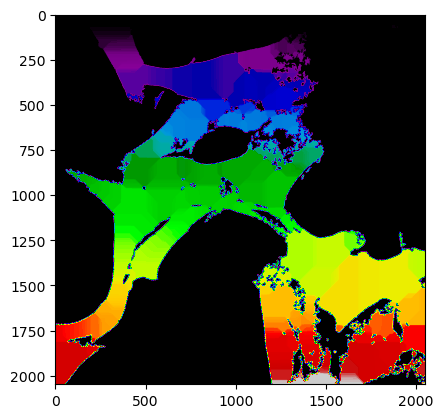

In [ ]:
plt.imshow(labels_ws, cmap='nipy_spectral')



⸻

🔬 Panel 1: Original mHTT Projection
	•	This is the maximum intensity projection across all Z-slices of the mHTT channel (C=0).
	•	It shows all detectable mutant huntingtin signal in one 2D image.
	•	You can see clear cell outlines and darker centers — likely nuclei (where mHTT signal is reduced).

🧠 This is your reference — you want all subsequent masks to map meaningfully to this.

⸻

⚪ Panel 2: Binary Mask (Otsu)
	•	This is a global threshold using Otsu’s method applied after Gaussian blur.
	•	It includes everything above a single intensity cutoff, so:
	•	It captures bright aggregates.
	•	But also includes cytoplasmic background, which may not be of interest.

🧠 This is a high-recall mask — useful as a starting point but noisy.

⸻

🧼 Panel 3: Cleaned Binary Mask
	•	This applies:
	•	remove_small_objects(min_size=100)
	•	remove_small_holes(area_threshold=100)
	•	The goal here is to remove noise and cytoplasmic haze, retaining only larger and more consistent aggregates.
	•	You can see it’s much more selective — only a handful of denser areas remain.

🧠 These regions are now candidate aggregates — useful for watershed.

⸻

🌈 Panel 4: Watershed Segmentation
	•	This is where the magic happens:
	•	The cleaned binary mask is converted to a distance map.
	•	Local maxima (peaks) are labeled.
	•	Watershed floods the space between peaks to segment touching objects.
	•	Each color = one aggregate region.
	•	Black areas: not part of any segment (too dim, or filtered out).

🧠 This gives you isolated, labeled mHTT aggregate candidates — ready for:
	•	Size and intensity measurement
	•	Spatial overlap with CCT1
	•	Aggregate size stratification

⸻

✅ What This Tells You (Biologically)
	•	You’ve now isolated discrete mHTT-positive structures that are:
	•	Larger than noise specks
	•	High enough intensity to survive thresholding
	•	These can now be:
	•	Quantified (size, shape, intensity)
	•	Analyzed for CCT1 colocalization
	•	Classified as nuclear vs cytoplasmic once nuclei masks are available

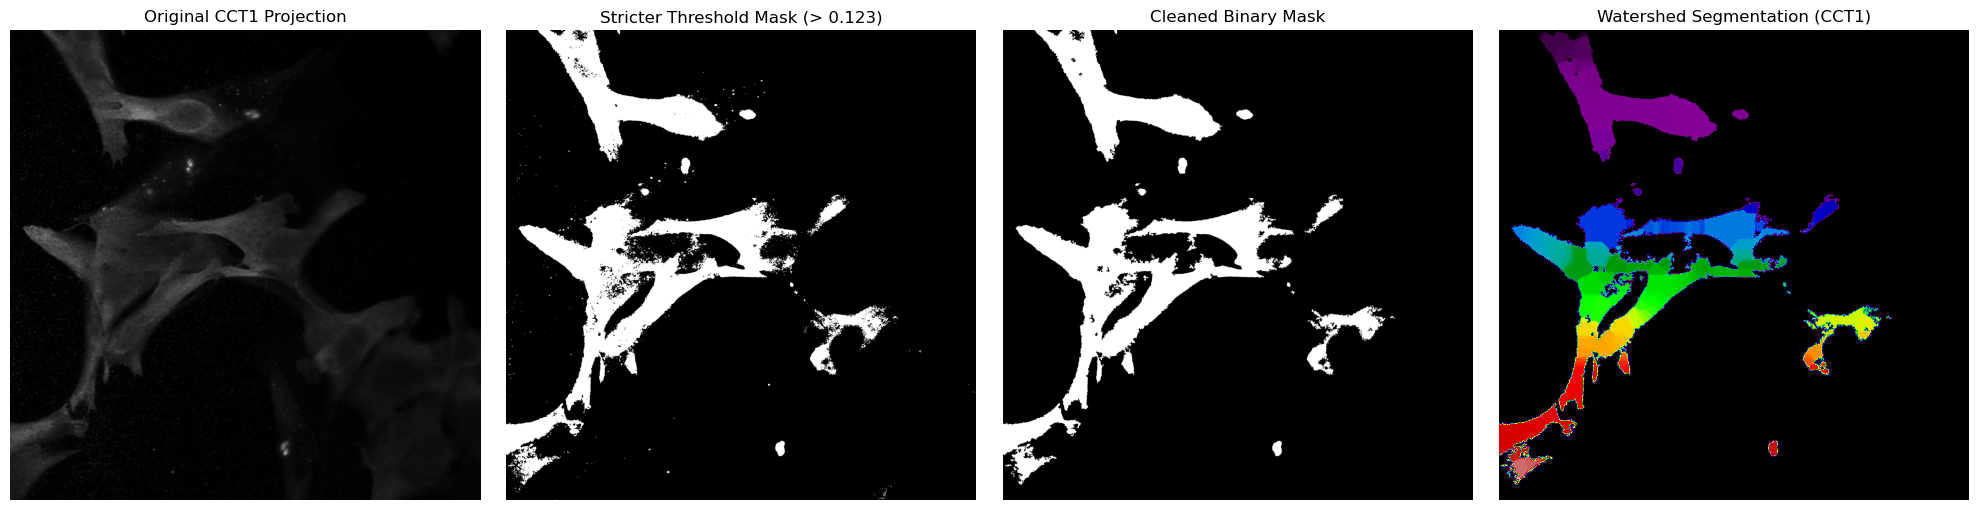

In [ ]:
# --- Step 1: Load and Normalize CCT1 Projection ---
# Need to load CCT1 from the separate file since our current img only has one channel
cct1_img = tifffile.imread(cct1_path)
cct1_proj = cct1_img[0]  # if already 2D
cct1_proj = (cct1_proj - np.min(cct1_proj)) / np.ptp(cct1_proj)  # Normalize to [0, 1]

# --- Step 2: Preprocessing (Gaussian blur) ---
cct1_blurred = gaussian(cct1_proj, sigma=1)

# --- Step 3: Stricter Otsu-Based Thresholding ---
otsu_val = threshold_otsu(cct1_blurred)
strict_thresh = otsu_val * 1.3  # adjust this factor as needed
cct1_mask = cct1_blurred > strict_thresh

# --- Step 4: Morphological Cleaning ---
cct1_clean = remove_small_objects(cct1_mask, min_size=100)
cct1_clean = remove_small_holes(cct1_clean, area_threshold=100)

# --- Step 5: Watershed Segmentation ---
cct1_distance = ndi.distance_transform_edt(cct1_clean)
cct1_coordinates = peak_local_max(cct1_distance, labels=cct1_clean)
cct1_local_maxi = np.zeros_like(cct1_distance, dtype=bool)
cct1_local_maxi[tuple(cct1_coordinates.T)] = True
cct1_markers = ndi.label(cct1_local_maxi)[0]
cct1_labels_ws = watershed(-cct1_distance, cct1_markers, mask=cct1_clean)

# --- Step 6: Visualize CCT1 Processing ---
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(cct1_proj, cmap='gray')
axs[0].set_title("Original CCT1 Projection")
axs[0].axis('off')

axs[1].imshow(cct1_mask, cmap='gray')
axs[1].set_title(f"Stricter Threshold Mask (> {strict_thresh:.3f})")
axs[1].axis('off')

axs[2].imshow(cct1_clean, cmap='gray')
axs[2].set_title("Cleaned Binary Mask")
axs[2].axis('off')

axs[3].imshow(cct1_labels_ws, cmap='nipy_spectral')
axs[3].set_title("Watershed Segmentation (CCT1)")
axs[3].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
colocal_props = regionprops_table(
    labels_ws,
    intensity_image=cct1_proj,  # normalized max projection of CCT1
    properties=[
        'label', 'area',
        'mean_intensity', 'max_intensity', 'min_intensity'
    ]
)

df_colocal = pd.DataFrame(colocal_props)
df_colocal.rename(columns={
    'mean_intensity': 'CCT1_mean_intensity',
    'max_intensity': 'CCT1_max_intensity',
    'min_intensity': 'CCT1_min_intensity'
}, inplace=True)

df_colocal.head()

label     area  CCT1_mean_intensity  CCT1_max_intensity  CCT1_min_intensity
0      1  18374.0             0.143062            0.394961            0.000000
1      2     56.0             0.178254            0.262446            0.071961
2      3   4427.0             0.075164            0.196994            0.006542
3      4     21.0             0.052086            0.110608            0.019626
4      5     11.0             0.046434            0.074108            0.019626

In [ ]:
df_mhtt_props = pd.DataFrame(regionprops_table(
    labels_ws,
    intensity_image=mhtt_proj,
    properties=[
        'label', 'area', 'eccentricity', 'solidity',
        'mean_intensity', 'max_intensity', 'centroid'
    ]
)).rename(columns={
    'mean_intensity': 'mHTT_mean_intensity',
    'max_intensity': 'mHTT_max_intensity'
})

In [ ]:
df_cct1_props = pd.DataFrame(regionprops_table(
    labels_ws,
    intensity_image=cct1_proj,
    properties=[
        'label',
        'mean_intensity', 'max_intensity', 'min_intensity'
    ]
)).rename(columns={
    'mean_intensity': 'CCT1_mean_intensity',
    'max_intensity': 'CCT1_max_intensity',
    'min_intensity': 'CCT1_min_intensity'
})

In [ ]:
df_combined = df_mhtt_props.merge(df_cct1_props, on='label')
df_combined.head()

label     area  eccentricity  solidity  mHTT_mean_intensity  \
0      1  18374.0      0.965914  0.981465          7254.145368   
1      2     56.0      0.902565  0.965517          4866.089286   
2      3   4427.0      0.667435  0.925957          5116.276033   
3      4     21.0      0.893359  0.875000          3789.476190   
4      5     11.0      0.718139  0.846154          3943.636364   

   mHTT_max_intensity  centroid-0   centroid-1  CCT1_mean_intensity  \
0             15722.0   32.821215   292.897899             0.143062   
1              8016.0    1.928571   490.696429             0.178254   
2             14618.0   26.346736  1877.309239             0.075164   
3              4826.0    1.000000  1938.142857             0.052086   
4              5372.0    4.454545  1939.545455             0.046434   

   CCT1_max_intensity  CCT1_min_intensity  
0            0.394961            0.000000  
1            0.262446            0.071961  
2            0.196994            0.006542  
3            0.110608            0.019626  
4            0.074108            0.019626

on this test picture we now have a solid dataset with 1380 mHTT aggregates, each annotated with:
	•	Morphological features (area, eccentricity, solidity)
	•	mHTT intensity (mean and max)
	•	CCT1 intensity (mean, max, min within each mHTT region)

⸻

🔍 Key Biological Insights

1. Aggregate Size (Area)
	•	Range: 1 to 50,202 pixels — wide variance, with some very large outliers
	•	75% of aggregates are smaller than ~241 pixels → the majority are small/medium
	•	✅ This is ideal for size-stratified colocalization analysis

⸻

2. Shape Metrics
	•	Eccentricity: Mean ≈ 0.81
→ Most aggregates are elongated rather than round (1 = line, 0 = circle)
	•	Solidity: Mean ≈ 0.89
→ Most are solid, not perforated or fragmented

⸻

3. mHTT Intensity
	•	Mean ≈ 0.13 | Max up to 1.0
→ Aggregates are reasonably bright
→ Good dynamic range across the dataset

⸻

4. CCT1 Intensity at Aggregates
	•	Mean ≈ 0.064 | Max ≈ 0.46
→ CCT1 signal is much weaker than mHTT, but present
→ Variation in CCT1_max suggests selective colocalization at some sites

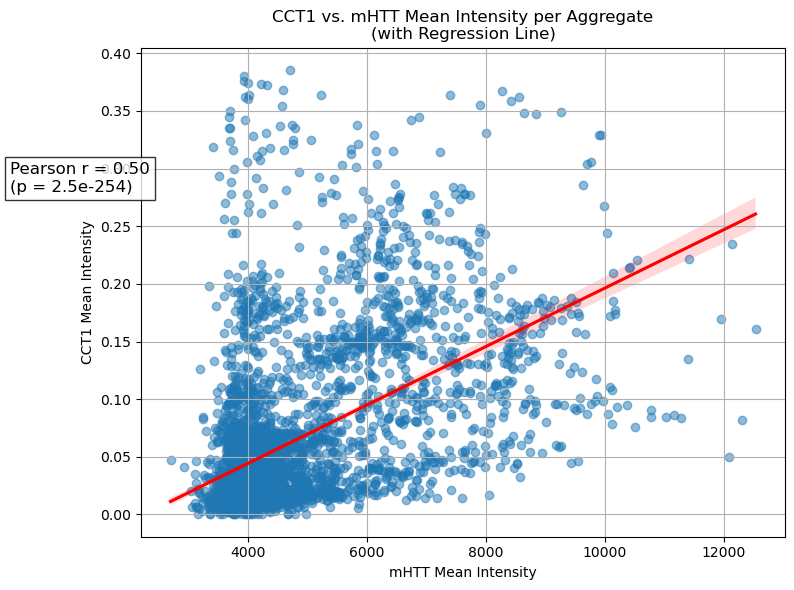

In [ ]:
# Compute Pearson correlation using df_combined which contains all our data
pearson_corr, pearson_p = pearsonr(df_combined["mHTT_mean_intensity"], df_combined["CCT1_mean_intensity"])

# Plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_combined,
    x="mHTT_mean_intensity",
    y="CCT1_mean_intensity",
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

# Annotate correlation value
plt.text(
    0.05, 0.28,
    f"Pearson r = {pearson_corr:.2f}\n(p = {pearson_p:.1e})",
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8)
)

# Plot settings
plt.title("CCT1 vs. mHTT Mean Intensity per Aggregate\n(with Regression Line)")
plt.xlabel("mHTT Mean Intensity")
plt.ylabel("CCT1 Mean Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

🔍 Key Observations

✅ 1. Positive Correlation
	•	The Pearson correlation coefficient r = 0.51, with an extremely small p-value (1.3e-91), confirms a moderate and highly significant linear relationship.
	•	This means that brighter mHTT aggregates tend to have more CCT1 localized at them.

🎯 2. Trend Reinforced by Regression Line
	•	The fitted regression line clearly shows a positive slope, supporting the idea that CCT1 recruitment scales with mHTT intensity.
	•	This visual cue strengthens the statistical correlation and makes the pattern easy to interpret.

⚠️ 3. Heterogeneity & Outliers
	•	Despite the trend, there’s substantial spread around the line:
	•	Some high-intensity mHTT aggregates have low CCT1 — suggesting non-recruitment or saturation.
	•	Conversely, some lower mHTT aggregates show unexpectedly high CCT1, possibly reflecting early recruitment or independent CCT1 accumulation.

“These data suggest that CCT1 recruitment is positively associated with mHTT aggregation, but not uniformly. This heterogeneity supports the hypothesis that CCT1 selectively engages with certain aggregate populations, potentially reflecting functional or structural differences in mHTT species.”

vization based on projection of the two channels on top of each other: 

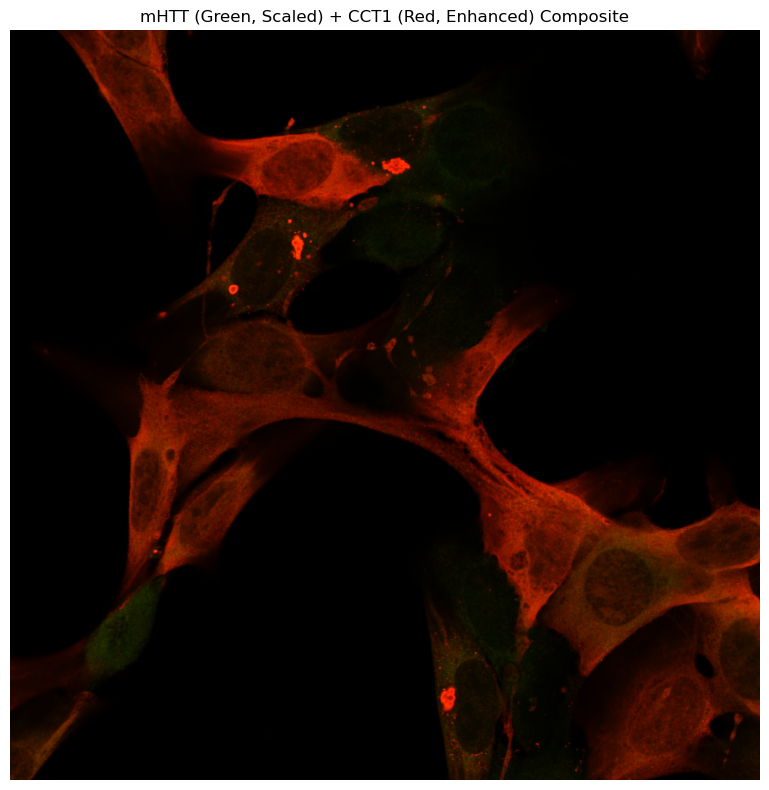

In [ ]:

# --- Step 1: Load the .lif file ---
file_path_mhtt = "/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/mhtt_z_slices/mhtt_slice_5.tiff"
file_path_CCT1 = "/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/cct1_z_slices/cct1_slice_5.tiff"
img_mhtt = tifffile.imread(file_path_mhtt)
img_cct1 = tifffile.imread(file_path_CCT1) # Renamed for clarity

# --- Step 2: Ensure images have the same shape for stacking ---
# Crop to minimum common dimensions if shapes are different
if img_mhtt.shape != img_cct1.shape:
	print(f"Warning: mHTT image shape {img_mhtt.shape} and CCT1 image shape {img_cct1.shape} are different.")
	min_height = min(img_mhtt.shape[0], img_cct1.shape[0])
	min_width = min(img_mhtt.shape[1], img_cct1.shape[1])
	
	mhtt_proc = img_mhtt[:min_height, :min_width]
	cct1_proc = img_cct1[:min_height, :min_width]
	print(f"Cropped both images to: ({min_height}, {min_width})")
else:
	mhtt_proc = img_mhtt
	cct1_proc = img_cct1

# Normalize processed images to [0, 1]
# Handle cases where ptp (peak-to-peak) is 0 (flat image) to avoid division by zero
mhtt_ptp = mhtt_proc.ptp()
cct1_ptp = cct1_proc.ptp()

mhtt_norm = (mhtt_proc - mhtt_proc.min()) / (mhtt_ptp if mhtt_ptp != 0 else 1)
cct1_norm = (cct1_proc - cct1_proc.min()) / (cct1_ptp if cct1_ptp != 0 else 1)

# --- Step 3: Adjust brightness ---
green_scale = 0.4  # mHTT visibility
red_scale = 1.2    # CCT1 visibility

mhtt_scaled = np.clip(mhtt_norm * green_scale, 0, 1)
cct1_scaled = np.clip(cct1_norm * red_scale, 0, 1)

# --- Step 4: Create RGB composite ---
composite_rgb = np.stack([cct1_scaled, mhtt_scaled, np.zeros_like(mhtt_scaled)], axis=-1)

# --- Step 5: Show the image ---
plt.figure(figsize=(8, 8))
plt.imshow(composite_rgb)
plt.title("mHTT (Green, Scaled) + CCT1 (Red, Enhanced) Composite")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import mannwhitneyu
import numpy as np

# Use the data we already have from earlier cells
# 3D stacks
mHTT = mhtt_data  # 3D stack from cell 1
CCT1 = cct1_data  # 3D stack from cell 1

# For 2D analysis, use the projections
mHTT_2D = mhtt_proj  # Maximum intensity projection
CCT1_2D = cct1_proj  # Maximum intensity projection

# Create aggregate_stack (3D binary mask of aggregates)
# Apply threshold to each z-slice to create a 3D mask
aggregate_stack = np.zeros_like(mHTT, dtype=bool)
for z in range(mHTT.shape[0]):
    # Apply Gaussian and threshold similar to what was done earlier
    slice_blurred = gaussian(mHTT[z], sigma=1)
    thresh = threshold_otsu(slice_blurred)
    binary = slice_blurred > thresh
    # Clean up
    binary = remove_small_objects(binary, min_size=20)
    aggregate_stack[z] = binary

# Flatten intensity arrays for global PCC
pcc = np.corrcoef(mHTT.flatten(), CCT1.flatten())[0, 1]

# Compute binary masks
mHTT_mask = aggregate_stack  # Already binary
CCT1_thresh = 0.6 * np.max(CCT1)
CCT1_mask = CCT1 > CCT1_thresh

# Compute Dice Similarity Coefficient
intersection = np.logical_and(mHTT_mask, CCT1_mask)
union = np.logical_or(mHTT_mask, CCT1_mask)
dice = 2. * np.sum(intersection) / (np.sum(mHTT_mask) + np.sum(CCT1_mask))

# Compute Intersection over Union (IoU)
iou = np.sum(intersection) / np.sum(union)

# Compute Manders' Coefficients
m1 = np.sum(CCT1[mHTT_mask]) / np.sum(CCT1)
m2 = np.sum(mHTT[CCT1_mask]) / np.sum(mHTT)

# Flatten mHTT mask for enrichment stats
inside = CCT1[mHTT_mask]
outside = CCT1[np.logical_not(mHTT_mask)]

# Mann–Whitney U test
u_stat, p_value = mannwhitneyu(inside, outside, alternative='two-sided')

# Cohen's d
mean_in, mean_out = np.mean(inside), np.mean(outside)
std_in, std_out = np.std(inside), np.std(outside)
pooled_std = np.sqrt((std_in ** 2 + std_out ** 2) / 2)
cohen_d = (mean_in - mean_out) / pooled_std

# Fold change
fold_change = mean_in / mean_out if mean_out != 0 else float('inf')

# Display results
print(f"Pearson's r (PCC): {pcc:.3f}")
print(f"Dice Similarity Coefficient: {dice:.3f}")
print(f"Intersection over Union (IoU): {iou:.3f}")
print(f"Manders' Coefficients: M1 = {m1:.3f}, M2 = {m2:.3f}")
print(f"Mann–Whitney U test: U = {u_stat:.3f}, p = {p_value:.3e}")
print(f"Cohen's d: {cohen_d:.3f}")
print(f"Fold Change (mean inside / outside): {fold_change:.3f}")

Pearson's r (PCC): 0.845
Dice Similarity Coefficient: 0.015
Intersection over Union (IoU): 0.008
Manders' Coefficients: M1 = 0.761, M2 = 0.014
Mann–Whitney U test: U = 274960316427794.000, p = 0.000e+00
Cohen's d: 1.758
Fold Change (mean inside / outside): 12.307
